# BNNs

In [1]:
from bayesian_models import Pbnn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from doepy import build
import pickle
from scipy.stats import norm, uniform, lognorm
from scipy.stats import qmc    #for sobol seq. (LHS is also available in this QuasiMC library)

In [3]:
from four_branch import four_branch

function = four_branch

def convert_lognormal(mean_ln, std_ln):
    gaussian_param = np.zeros(2)

    SigmaLogNormal = np.sqrt( np.log(1+(std_ln/mean_ln)**2))
    MeanLogNormal = np.log( mean_ln ) - SigmaLogNormal**2/2

    gaussian_param[0] = MeanLogNormal
    gaussian_param[1] = SigmaLogNormal

    return gaussian_param

In [5]:
dim = 2
n_mcs = int(1e5)
x_test = np.random.normal(0, 1, size=(n_mcs, dim))

y_test = function(x_test)
Pf_ref = np.sum( y_test < 0 ) / n_mcs
B_ref= - norm.ppf( Pf_ref )
Pf_ref, B_ref

(0.00438, 2.6212810950879932)

In [6]:
delta = 0.025
x1 = np.arange(-5.0, 5.0, delta)
x2 = np.arange(-5.0, 5.0, delta)
X1, X2 = np.meshgrid(x1, x2)
Xt=np.stack((X1,X2),axis=2).reshape(-1,2) #sorting the random sampling (graph purposes)
Yt = function(Xt)

to sample with sobol

In [47]:
sampler = qmc.Sobol(d=2, scramble=True)    #d=dimensionality
sample = sampler.random_base2(m=9)   #change m=exponent to increase the sample size

l_bounds = [-2.0, -2.0]  #design domain for each variable in the physical space
u_bounds = [2.0, 2.0]
X = qmc.scale(sample, l_bounds, u_bounds)

Y = function(X)
len(X)

512

to sample with LHS

In [52]:
passive_samples = 200
X = np.zeros((passive_samples, dim))

exp_norm = {}
for var_name in range(dim):
    exp_norm['x'+ str(var_name+1)] = [-2, 2]    #initial design domain for each variable in the physical space
#Latin hypercube sampling
Xdoe = build.space_filling_lhs(exp_norm , num_samples = passive_samples)

for margin in range (0, dim):
    var = 'x' + str (margin + 1)
    X[:, margin] = Xdoe[var]

Y = function(X)

Plot 2D - initial DoE

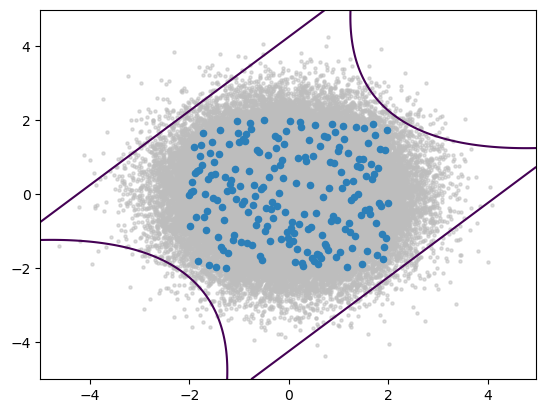

In [70]:
fig, ax = plt.subplots()
ax.scatter(x_test[:,0], x_test[:,1], s=5, alpha=0.5, c='#bdbdbd')
ax.scatter(X[:,0], X[:,1], s=20, alpha=1, c='#2c7fb8')
CS = ax.contour(X1, X2, Yt.reshape(len(x1),-1), [0])
# ax.clabel(CS, inline=False, fontsize=10)

BNN training

In [72]:
dim = 2
output = 1
layers, archit = 2 , [16, 16] #ange archit size if layers are increased

#-------------------------------------------creating bnn
#setting up the network architecture -----------------------------------
config = {"n_infeatures": dim,
        "n_outfeatures": output,
        "n_samples": len(X),
        "learn_all_params": False,  #to learn mean and sigma
        "fixed_param": 0.001} 

mybnn = Pbnn(config)
mybnn.build_bnn(layers, archit) #----------------------------------------------------------MODEL ARCHITECTURE

c:\Users\Administrator\anaconda3\envs\deep_learning\lib\site-packages\tensorflow_probability\python\layers\util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
c:\Users\Administrator\anaconda3\envs\deep_learning\lib\site-packages\tensorflow_probability\python\layers\util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [77]:
training_epochs = 2000
batch_size = len(X)
# batch_size = [np.floor_divide(len(X), 2)][0] + 1  # half of the DoE
#-------------------------------------------training bnn
train_env = {"batch_size": batch_size,
            "learning_rate": 0.001,
            "epochs": training_epochs,
            "callback_patience": 500,
            "verbose": 1,
            "valid_split":0.3}
print('Training BNN With', len(X), 'samples' )
history = mybnn.train_bnn(X, Y, train_env)

Training BNN With 200 samples
Epoch 1/2000
1/1 [==============================] - 3s 3s/step - loss: 57657.7500 - val_loss: 37719.4531
Epoch 2/2000
1/1 [==============================] - 1s 553ms/step - loss: 19905.4102 - val_loss: 25314.2949
Epoch 3/2000
1/1 [==============================] - 1s 537ms/step - loss: 18384.5742 - val_loss: 24558.2891
Epoch 4/2000
1/1 [==============================] - 0s 331ms/step - loss: 19873.3594 - val_loss: 21524.4883
Epoch 5/2000
1/1 [==============================] - 0s 334ms/step - loss: 20760.1504 - val_loss: 48247.7305
Epoch 6/2000
1/1 [==============================] - 0s 318ms/step - loss: 23356.2070 - val_loss: 28847.5586
Epoch 7/2000
1/1 [==============================] - 0s 351ms/step - loss: 36033.3828 - val_loss: 27875.6836
Epoch 8/2000
1/1 [==============================] - 0s 325ms/step - loss: 20623.6387 - val_loss: 31747.7070
Epoch 9/2000
1/1 [==============================] - 0s 300ms/step - loss: 30464.2598 - val_loss: 29941.3809
E

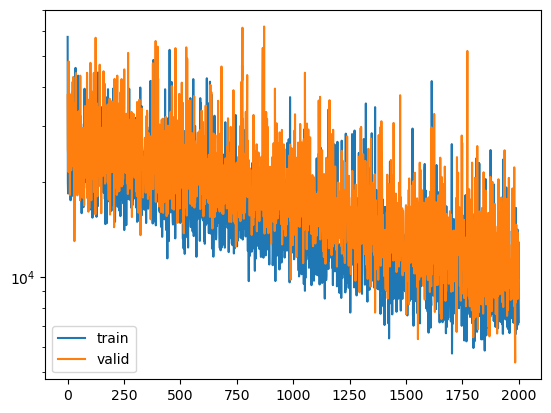

In [78]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(train_loss, label='train')
ax.plot(val_loss, label='valid')

ax.set_yscale('log')
plt.legend()
plt.show()

In [79]:
bnn_simulations = 300
Mean_muY_val, Stdv_muY_val, Mean_sigmaY_val, Stdv_sigmaY_val = mybnn.modeluq_bnn(Xt, nsim = bnn_simulations)

<a list of 3 text.Text objects>

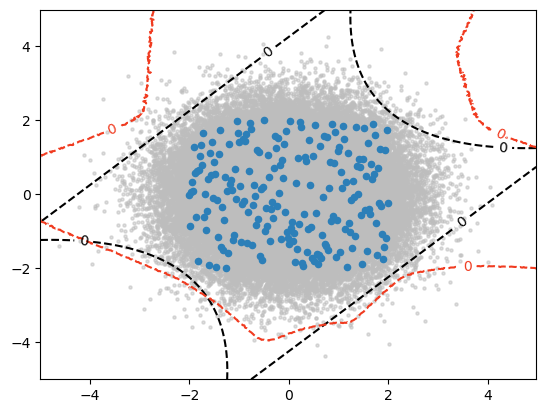

In [80]:
fig, ax = plt.subplots()
ax.scatter(x_test[:,0], x_test[:,1], s=5, alpha=0.5, c='#bdbdbd')
ax.scatter(X[:,0], X[:,1], s=20, alpha=1, c='#2c7fb8')
CS = ax.contour(X1, X2, Yt.reshape(len(x1),-1), [0], colors='k', linestyles='dashed')
CB = ax.contour(X1, X2, Mean_muY_val.reshape(len(x1),-1), [0], colors='#f03b20', linestyles='dashed')
ax.clabel(CS, inline=True, fontsize=10)
ax.clabel(CB, inline=True, fontsize=10)

In [82]:
n_mcs = int(1e6)
bnn_simulations = 300

exp = {'x1': [0, 1, 'normal'],
       'x2': [0, 1, 'normal']}

#-------------------------------------------MC population
Xtest = np.zeros((int(n_mcs), dim))
MCinputs_norm= np.random.uniform(0.000001, 0.999999, size=(int(n_mcs), dim))

##Iso-probabilistic transformation-------------------------------------------
for margin in range (0, dim):
    var = 'x' + str (margin + 1)

    if exp[var][2] == 'normal':
        loc_ = exp[var][0]
        scale_ = exp[var][1]
        Xtest[:, margin] = norm.ppf(MCinputs_norm[:, margin], loc=loc_, scale=scale_)

    elif exp[var][2] == 'uniform':
        loc_ = exp[var][0]
        scale_ = exp[var][1]
        Xtest[:, margin] = uniform.ppf(MCinputs_norm[:, margin], loc=loc_, scale=scale_-loc_)

    elif exp[var][2] == 'lognormal':
        xlog_mean = exp[var][0]
        xlog_std = exp[var][1]
        gaussian_param = convert_lognormal(xlog_mean, xlog_std)
        Xtest[:, margin] = lognorm.ppf(MCinputs_norm[:, margin], s=gaussian_param[1], scale=xlog_mean) 

#-------------------------------------------model predictions over MC population
print('BNN predictions with MC population...')
Mean_muY_MC, Stdv_muY_MC, Mean_sigmaY_MC, Stdv_sigmaY_MC = mybnn.modeluq_bnn(Xtest, nsim = bnn_simulations)
y_mcs = function(Xtest)

PF = np.sum(Mean_muY_MC < 0) / n_mcs
PF_ref = np.sum(y_mcs < 0) / n_mcs
B = - norm.ppf( PF )

print('PF_ref =', PF_ref,'PF =', PF, 'and B =',"%.5f" % round(B, 3))

BNN predictions with MC population...
PF_ref = 0.004468 PF = 0.001106 and B = 3.06000


In [ ]:
#-------------------------------------------Selecting new training point
U_f = np.abs(Mean_muY_MC) / Stdv_muY_MC
U_min = np.argmin(U_f)
X_new = Xtest[U_min].reshape(-1, dim)
X = np.concatenate((X, X_new), axis=0)

Y_new = function(X_new)
Y = np.concatenate((Y, Y_new), axis=0)
print(Y)